# **Time Series Forecasting with ARIMA**

****

Dataset used: Google stock price data using the Yahoo Finance API

In [3]:
import pandas as py
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

In [4]:
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG', start = start_date, end = end_date, progress = False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2023-10-17  140.029999  141.250000  138.529007  140.990005  140.990005   
247 2023-10-18  140.750000  141.990005  138.705002  139.279999  139.279999   
248 2023-10-19  139.800003  141.005005  138.600006  138.979996  138.979996   
249 2023-10-20  138.589996  139.039993  136.244995  136.740005  136.740005   
250 2023-10-23  136.229996  139.020004  135.119995  137.899994  137.899994   

       Volume  
246  17424000  
247  18304900  
248  21831200  
249  24953900  
250  20043693  


In [5]:
data = data[["Date","Close"]]
print(data.head())

        Date       Close
0 2022-10-24  102.970001
1 2022-10-25  104.930000
2 2022-10-26   94.820000
3 2022-10-27   92.599998
4 2022-10-28   96.580002


Visualizing close prices of Google

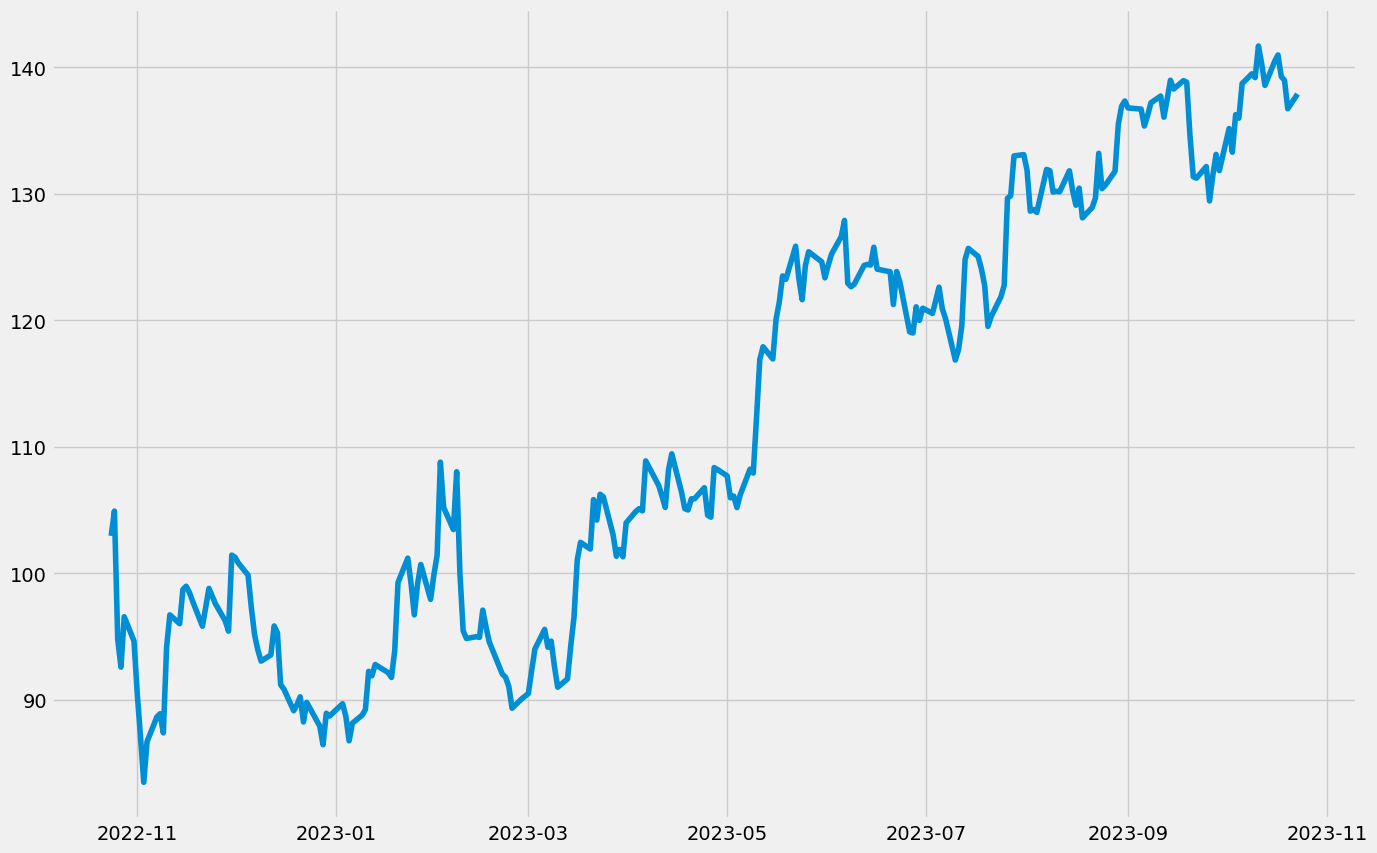

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,10))
plt.plot(data["Date"], data["Close"])

Using the *seasonal decomposition* method to split the series data into - trend, seasonal & residuals

<Figure size 640x480 with 0 Axes>

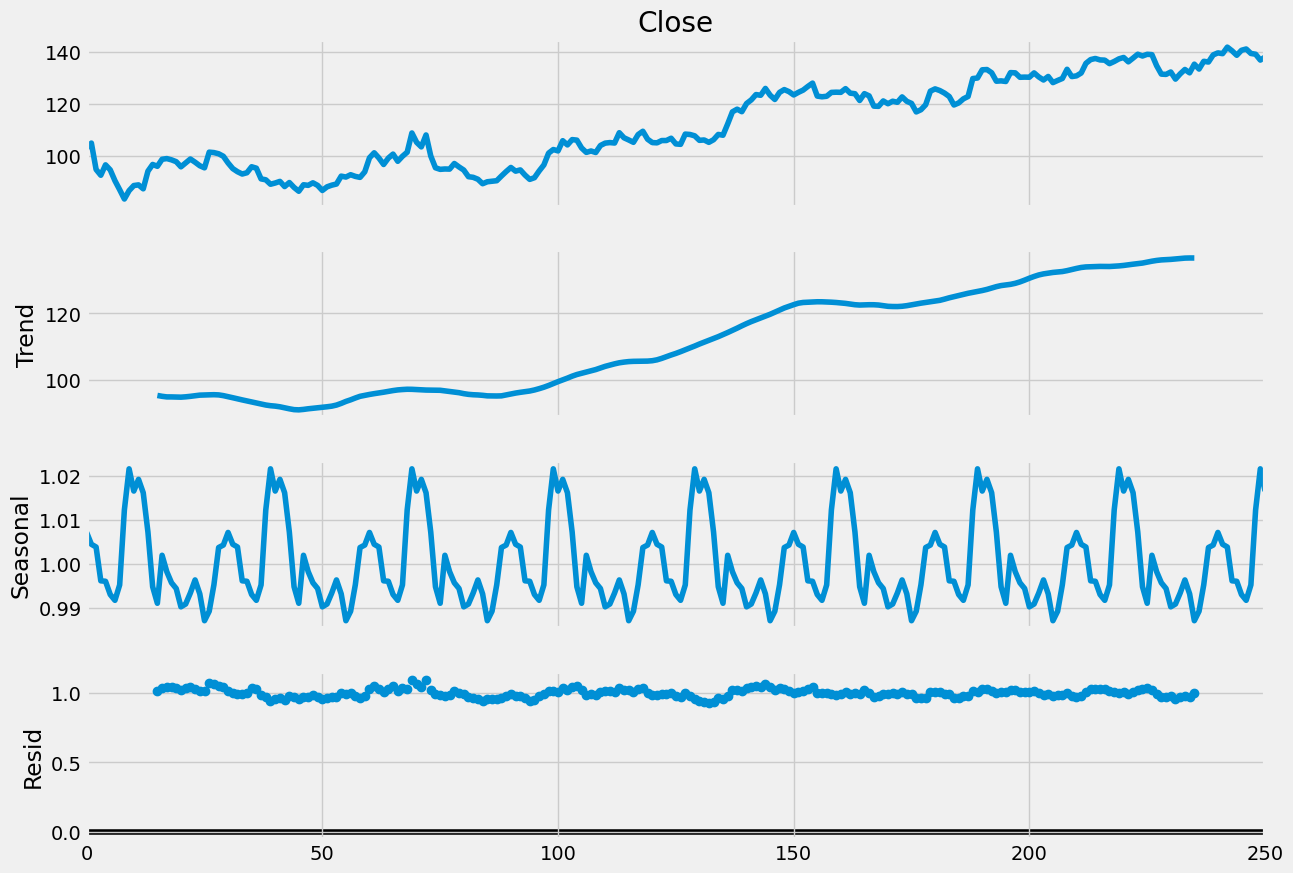

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], model = 'multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15,10)

**Preprocessing**

****

1. Finding the p,d and q values

(I) Finding the value of p by plotting the autocorrelation of the Close column

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

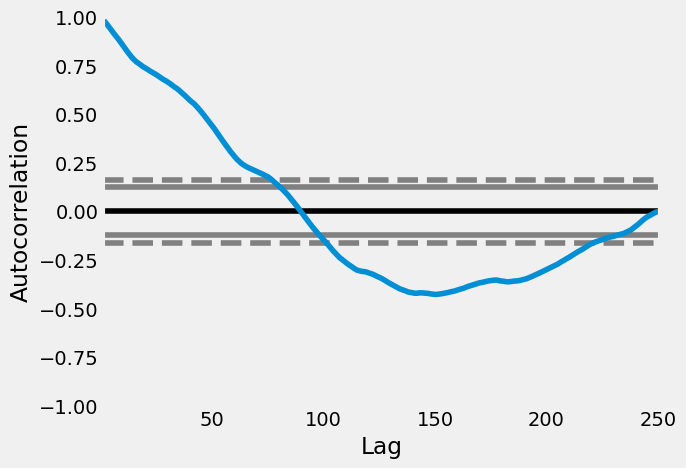

In [10]:
py.plotting.autocorrelation_plot(data["Close"])

{since the curve is moving down after the 5th line of the first boundary, p-value = 5}

(II) Determining the value of q by plotting the partial autocorrelation plot

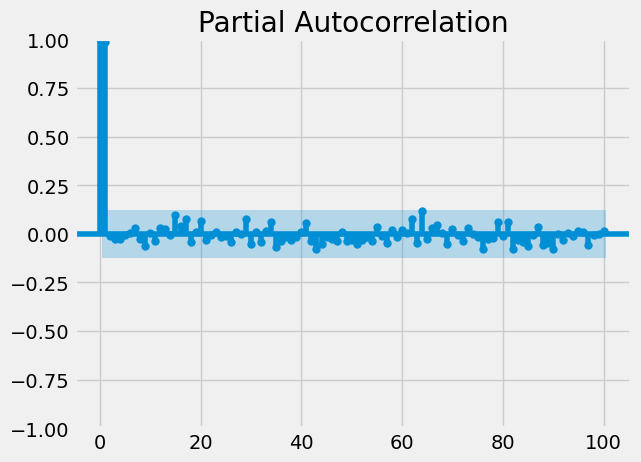

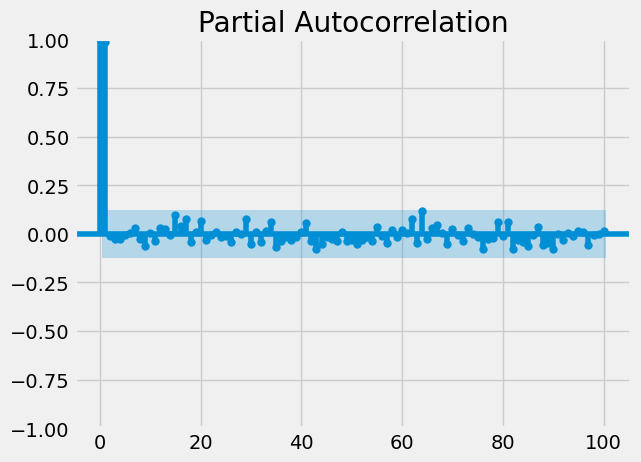

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

{From the above, we can see that only two points are far away from all the points. Thus, q-value = 2}

(III) Value of d = 0 or 1                       (stationary data = 0, seasonal data = 1) {we choose 1}

****

**Building the SARIMA model**

In [16]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00


In [17]:
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt

data = py.DataFrame(data["Close"])
p,d,q = 5,1,2

#Fit the ARIMA model using pmdarima's auto_arima
model = auto_arima(data, start_p=1, start_d=1, start_q=1, max_p=p, max_d=d, max_q=q, seasonal=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  251
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -559.423
Date:                Tue, 24 Oct 2023   AIC                           1120.846
Time:                        07:37:31   BIC                           1124.367
Sample:                             0   HQIC                          1122.263
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.1423      0.322     15.960      0.000       4.511       5.774
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                47.56
Prob(Q):                              0.53   Pr

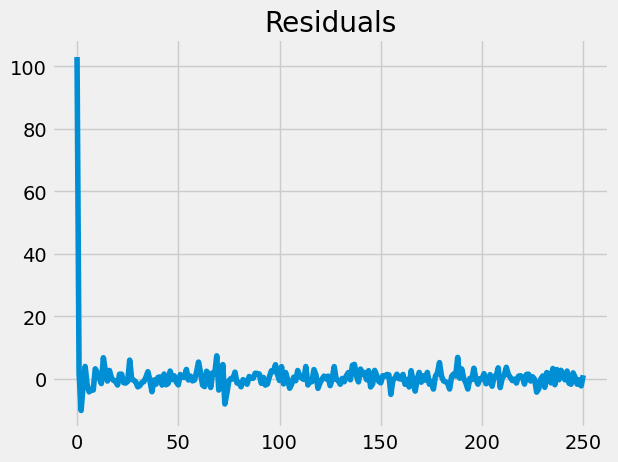

In [19]:
#plot the residuals
plt.plot(model.resid())
plt.title('Residuals')
plt.show()

**Predictions**

****

Predicting the  future stock prices using SARIMA model for the next 10 days

In [22]:
predictions = model.predict(len(data), len(data) + 10)
print(predictions)

251    137.899994
252    137.899994
253    137.899994
254    137.899994
255    137.899994
          ...    
497    137.899994
498    137.899994
499    137.899994
500    137.899994
501    137.899994
Length: 251, dtype: float64


Plotting the predictions

<Axes: >

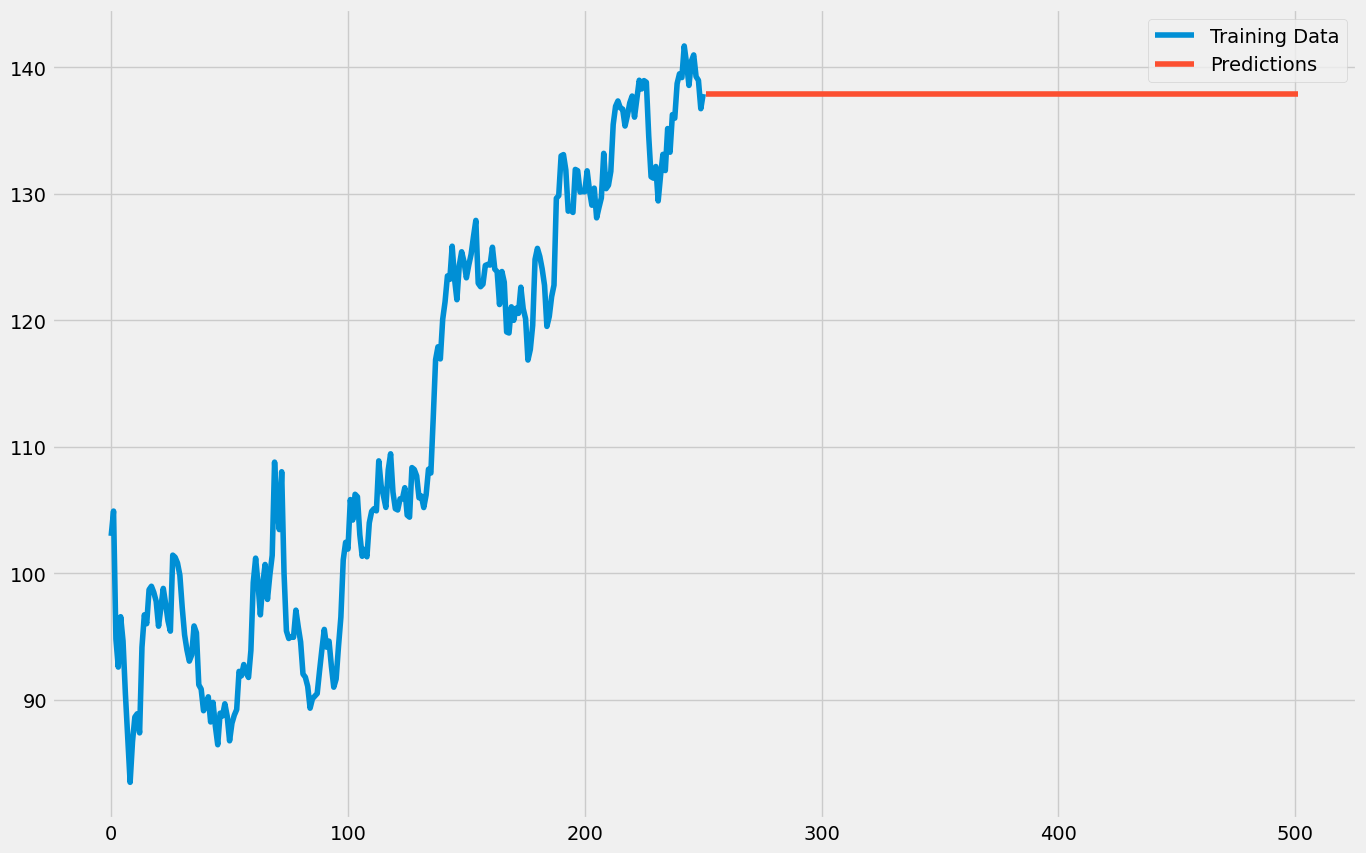

In [23]:
data["Close"].plot(legend=True, label = "Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

**Evaluation Metrics**

In [30]:
from sklearn.metrics import mean_absolute_error

# Calculate the MAE for the predictions
mae = mean_absolute_error(data["Close"].iloc[-10:], predictions)
print("Mean Absolute Error (MAE) for predictions:", mae)

# Calculate the MAE for the overlapping portion of the training data and predictions
training_mae = mean_absolute_error(data["Close"].iloc[-20:-10], predictions[:10])
print("Mean Absolute Error (MAE) for training data:", training_mae)

Mean Absolute Error (MAE) for predictions: 1.747003173828125
Mean Absolute Error (MAE) for training data: 3.9009933471679688


In [31]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have the actual values and predictions
actual_values = data["Close"].iloc[-10:]
predictions = predictions

# Calculate MAE
mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

# Calculate R-squared (R²)
r_squared = r2_score(actual_values, predictions)
print("R-squared (R²):", r_squared)


Mean Absolute Error (MAE): 1.747003173828125
Root Mean Squared Error (RMSE): 2.0730957833057895
Mean Absolute Percentage Error (MAPE): nan %
R-squared (R²): -1.1461969690357705


<ipython-input-31-137835dd00df>:17: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((actual_values - predictions) / actual_values)) * 100
